# Analyzing Links using SmappDragon
by [Leon Yin](twitter.com/leonyin)<br>
2018-02-16

This Tutorial shows how to 
1. <a href="#tweep">Download tweets from Twitter using Tweepy</a>,
2. <a href="#filter">Filter and parse tweets using SmappDragon</a>,
3. <a href="#link">Create a link metadata table using SmappDragon</a>, and
4. <a href="#fake">Analyze links from questionable websites using Pandas and the OpenSources.co dataset</a>.

View this on [Github](https://github.com/yinleon/smappdragon-tutorials/blob/master/smappdragon-tutorial-link-analysis.ipynb).
View this on [NBViewer](https://nbviewer.jupyter.org/github/yinleon/smappdragon-tutorials/blob/master/smappdragon-tutorial-link-analysis.ipynb).
Visit my Lab's [website](https://wp.nyu.edu/smapp/)

## Downloading Tweets with Tweepy <a id='tweep'></a>

In [1]:
# !pip install requirements.txt

In [2]:
import os
import json
import tweepy
from smappdragon import JsonCollection

In [3]:
# fill these in with your Twitter API credentials, I store them as enviornment variables.
consumer_key = os.environ.get('TWEEPY_API_KEY')
consumer_secret = os.environ.get('TWEEPY_API_SECRET')
access_key = os.environ.get('TWEEPY_ACCESS_TOKEN')
access_secret = os.environ.get('TWEEPY_TOKEN_SECRET')

In [4]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth, retry_count=2, retry_delay=5, 
                 wait_on_rate_limit=True,
                 wait_on_rate_limit_notify=True)

In [5]:
screen_name = 'seanhannity'

We can use the tweepy `Cursor` to hit the Twitter API for up to 3.2K tweets per user.

In [6]:
user_tweets= []
for tweet in tweepy.Cursor(api.user_timeline, screen_name=screen_name).items():
    user_tweets.append(tweet._json)
len(user_tweets)

3230

Let's store this data in a new directory.

In [ ]:
!mkdir ./data

In [ ]:
tweet_file = './data/tweets.json'

In [7]:
with open(tweet_file, 'w') as f:
    for tweet in user_tweets:
        f.write(json.dumps(tweet) + '\n')

We could work with this JSON in a variety of ways.<br>
At my lab we created a module which works wih JSON records in a `collection` object.

In [8]:
collect = JsonCollection(tweet_file, throw_error=0, verbose=1)

In [9]:
collect

We access the tweets stored in the `collect` the same way for any generator.

In [10]:
collect.get_iterator()

<generator object JsonCollection.get_iterator at 0x10bda0308>

## What is  generator?
A generator is an interator that only keeps track of location.<br>
In other words, the entirety of the tweet json is not held in memory.<br>
They are created by functions that _yield_ objects, rather than _return_ objects.

In [11]:
def simple_generator_function():
    yield 1
    yield 2
    yield 3

In [12]:
gen = simple_generator_function()

In [13]:
gen

<generator object simple_generator_function at 0x10bda0f68>

We see that this is similar to what is returned from `collect.get_iterator()`.<br>
We access the values in a generator by iterating through it.<br>
For loops are the easiest way to iterate.

In [14]:
for i in gen:
    print(i)

1
2
3


Notice, when a generator is iterated through, it is no longer usable.

In [15]:
for i in gen:
    print(i)

When we use the `get_iterator` function, we convert the collection into a generator.
Unlike conventional generators, when do use this function, we can contiue to iterate through the object.

In [16]:
for tweet in collect.get_iterator():
    print(json.dumps(tweet, indent=2))
    break

{
  "created_at": "Fri Feb 16 02:47:44 +0000 2018",
  "id": 964330423466778624,
  "id_str": "964330423466778624",
  "text": "Dr. Daniel Bober and @RealDrGina are next with how you can spot the warning signs that a tragic event might happen #Hannity",
  "truncated": false,
  "entities": {
    "hashtags": [
      {
        "text": "Hannity",
        "indices": [
          115,
          123
        ]
      }
    ],
    "symbols": [],
    "user_mentions": [
      {
        "screen_name": "RealDrGina",
        "name": "Gina Gentry Loudon",
        "id": 20118767,
        "id_str": "20118767",
        "indices": [
          21,
          32
        ]
      }
    ],
    "urls": []
  },
  "source": "<a href=\"http://twitter.com/download/iphone\" rel=\"nofollow\">Twitter for iPhone</a>",
  "in_reply_to_status_id": null,
  "in_reply_to_status_id_str": null,
  "in_reply_to_user_id": null,
  "in_reply_to_user_id_str": null,
  "in_reply_to_screen_name": null,
  "user": {
    "id": 41634520,
    "i

We're breaking only because we don't want to print all the tweets in our json file.

## Crunching Numbers <a id="filter"></a>
We can study the structure of each tweet, and crunch some numbers.<br>
For this example let's count who the user is tweeting with?

In [18]:
from collections import Counter

counter = Counter()
for tweet in collect.get_iterator():
    for user in tweet['entities']['user_mentions']:
        counter.update([user['screen_name']])
    
counter.most_common(10)

3229 rows are ok.
0 rows are corrupt.


[('SaraCarterDC', 159),
 ('newtgingrich', 130),
 ('JaySekulow', 117),
 ('GreggJarrett', 102),
 ('GeraldoRivera', 91),
 ('SebGorka', 90),
 ('IngrahamAngle', 85),
 ('POTUS', 82),
 ('realDonaldTrump', 79),
 ('seanhannity', 74)]

We can also created conditional statements to filter the data.

In [19]:
def exclude_retweets(tweet):
    '''
    An example of a filter for a smappcollection.
    Either True or False, the input will always be a json record.
    '''
    if tweet['retweeted'] == True:
        return False
    return True

In [20]:
collect.set_custom_filter(exclude_retweets)

In [21]:
filtered_tweets = []
for tweet in collect.get_iterator():
    filtered_tweets.append(tweet)

len(filtered_tweets)

3229 rows are ok.
0 rows are corrupt.


3230

We can dump the filtered collection to a compressed csv.

In [22]:
filtered_tweet_file = 'tweets_filtered.csv.gz'
collect.dump_to_csv(filtered_tweet_file, 
                    input_fields = ['user.id', 'text', 'created_at'], 
                    compression = 'gzip')

3229 rows are ok.
0 rows are corrupt.


What are the columns available for the `input_fields` argument?

In [23]:
def get_all_columns(d, key=[]):
    '''
    A recursive function that traverses json keys.
    The values return
    '''
    if not isinstance(d, dict):
        print('.'.join(key))
        return
    
    for k, v in d.items():
        key_path = key + [k]
        get_all_columns(d[k], key_path)

In [24]:
get_all_columns(tweet)

created_at
id
id_str
text
truncated
entities.hashtags
entities.symbols
entities.user_mentions
entities.urls
source
in_reply_to_status_id
in_reply_to_status_id_str
in_reply_to_user_id
in_reply_to_user_id_str
in_reply_to_screen_name
user.id
user.id_str
user.name
user.screen_name
user.location
user.description
user.url
user.entities.url.urls
user.entities.description.urls
user.protected
user.followers_count
user.friends_count
user.listed_count
user.created_at
user.favourites_count
user.utc_offset
user.time_zone
user.geo_enabled
user.verified
user.statuses_count
user.lang
user.contributors_enabled
user.is_translator
user.is_translation_enabled
user.profile_background_color
user.profile_background_image_url
user.profile_background_image_url_https
user.profile_background_tile
user.profile_image_url
user.profile_image_url_https
user.profile_banner_url
user.profile_link_color
user.profile_sidebar_border_color
user.profile_sidebar_fill_color
user.profile_text_color
user.profile_use_background_i

## Link Analysis <a id="link"></a>
Let's parse out all the links out of the tweet.<br>
We can't just return the value, as there can be multiple links per Tweet.<br>
We can solve this by using a generator, and unpacking each using `itertools`.

In [25]:
import itertools
import requests
from urllib.parse import urlparse
import pandas as pd

In [26]:
def get_link(tweet):
    '''
    Returns a generator containing tweet metadata about media.
    '''
    if not isinstance(tweet, dict):
        return
        
    row = {
        'user.id': tweet['user']['id'],
        'tweet.id': tweet['id'],
        'tweet.created_at': tweet['created_at'],
        'tweet.text' : tweet['text']
    }

    list_urls = tweet['entities']['urls']
    
    if list_urls:
        for url in list_urls:
            r = row.copy()
            r['link.url_long'] = url.get('expanded_url')
            
            if r['link.url_long']:
                r['link.domain'] = urlparse(r['link.url_long']).netloc.lower().lstrip('www.')
                r['link.url_short'] = url.get('url')

                yield r  

In [27]:
df_links = pd.DataFrame(
    list(
        itertools.chain.from_iterable(
            [ get_link(tweet) for tweet in collect.get_iterator() if tweet ]
        )
    )
)

3229 rows are ok.
0 rows are corrupt.


In [28]:
df_links.head()

,link.domain,link.url_long,link.url_short,tweet.created_at,tweet.id,tweet.text,user.id
0,twitter.com,https://twitter.com/i/web/status/9643237186746...,https://t.co/VkG8xp9cph,Fri Feb 16 02:21:05 +0000 2018,964323718674644993,Coming up... President Trump is vowing tough a...,41634520
1,twitter.com,https://twitter.com/i/web/status/9643128779927...,https://t.co/RL57eiZmas,Fri Feb 16 01:38:00 +0000 2018,964312877992734721,Tonight on #Hannity I’m joined by @JudgeJeanin...,41634520
2,hannity.com,https://www.hannity.com/media-room/capitol-rev...,https://t.co/31pzBs5ulS,Thu Feb 15 21:56:52 +0000 2018,964257227900116993,https://t.co/31pzBs5ulS,41634520
3,hannity.com,https://www.hannity.com/media-room/nice-try-th...,https://t.co/FVWAi8hzlH,Thu Feb 15 21:14:18 +0000 2018,964246514561363974,Nice try Joy https://t.co/FVWAi8hzlH,41634520
4,hannity.com,https://www.hannity.com/media-room/red-flag-fb...,https://t.co/BltIZp6vOd,Thu Feb 15 20:18:17 +0000 2018,964232417107173376,WATCH: FBI Agent comments on claims the bureau...,41634520


In [29]:
# filter out Twitter links
df_links = df_links[df_links['link.domain'] != 'twitter.com']

We can also expand shortened links fron bit.ly

In [31]:
def resolve_shortened_link(link):
    '''
    Handles link shorteners like bit.ly.
    '''
    if link['link.domain'] in ['bit.ly']:
        r = requests.head(link['link.url_long'], allow_redirects=True)
        return r.url
    else:
        return link['link.domain']

We use the `apply()` function on a Pandas dataframe to apply a function to entire rows (`axis=1`) or columns (`axis=2`)

In [33]:
df_links.loc[:, 'link.domain'] = df_links.apply(resolve_shortened_link, axis=1)

In [34]:
df_links['link.domain'].value_counts().head(15)

hannity.com           302
amzn.to                37
thehill.com            31
mediaequalizer.com     22
angelocarusone.com     19
youtu.be               14
breitbart.com          12
mediaite.com           11
foxnews.com             9
youtube.com             8
ashingtonpost.com       7
dailycaller.com         6
circa.com               6
ashingtontimes.com      6
google.com              6
Name: link.domain, dtype: int64

We can see the most common words associated with each link using a simple count sans-stop words.

In [35]:
from nltk.corpus import stopwords

What does his own site focus on?

In [36]:
word_count = Counter()
for sent in df_links[df_links['link.domain'] == 'hannity.com']['tweet.text'].values:
    word_count.update([w for w in sent.split() if w not in stopwords.words('English')])

word_count.most_common(10)

[('Trump', 19),
 ('FBI', 13),
 ('Over', 13),
 ('GOP', 12),
 ('The', 11),
 ('https://t.co/9hkyEX1UVi', 11),
 ('@realDonaldTrump', 10),
 ('Tax', 10),
 ('After', 8),
 ('Cuts', 8)]

What about Amazon?

In [37]:
word_count = Counter()
for sent in df_links[df_links['link.domain'] == 'amzn.to']['tweet.text']:
    word_count.update([w for w in sent.split() if w not in stopwords.words('English')])

word_count.most_common(10)

[('radio', 26),
 ('joins', 19),
 ('new', 19),
 ('book', 15),
 ('discuss', 11),
 ('great', 7),
 ('talk', 7),
 ('#Hannity', 7),
 ('author', 4),
 ('.@newtgingrich', 4)]

## Questionable Media Domains <a id="fake"></a>
We can use the open sources dataset to filter domains on various criteria.<br>
Here is a <a href="https://nbviewer.jupyter.org/github/yinleon/fake_news/blob/master/opensources-lite.ipynb">notebook</a> that makes the data machine-readible.

In [38]:
opensorces_clean_url = 'https://raw.githubusercontent.com/yinleon/fake_news/master/data/sources_clean.tsv'
df_os = pd.read_csv(opensorces_clean_url, sep='\t')

In [39]:
df_os.head()

,domain,bias,clickbait,conspiracy,fake,hate,junksci,political,reliable,rumor,satire,state,unreliable,notes
0,100percentfedup.com,1,0,0,0,0,0,0,0,0,0,0,0,NaN
1,16wmpo.com,0,0,0,1,0,0,0,0,0,0,0,0,http://www.politifact.com/punditfact/article/2...
2,21stcenturywire.com,0,0,1,0,0,0,0,0,0,0,0,0,NaN
3,24newsflash.com,0,0,0,1,0,0,0,0,0,0,0,0,NaN
4,24wpn.com,0,0,0,1,0,0,0,0,0,0,0,0,http://www.politifact.com/punditfact/article/2...


In [40]:
df_questionable = pd.merge(left= df_links, left_on= 'link.domain', 
                           right= df_os, right_on= 'domain', how= 'inner')

What is the breakdown of links shared from questionable sites?

In [41]:
df_questionable['link.domain'].value_counts()

breitbart.com                12
dailycaller.com               6
theblaze.com                  3
lifezette.com                 3
americanthinker.com           3
nationalreview.com            2
freebeacon.com                2
conservativetribune.com       1
thedailybeast.com             1
pjmedia.com                   1
cnsnews.com                   1
ijr.com                       1
conservapedia.com             1
thegatewaypundit.com          1
newsmax.com                   1
conservativereview.com        1
thefreethoughtproject.com     1
Name: link.domain, dtype: int64

We can do some simple matrix math to see the breakdown of quesitonable links

In [42]:
# these are the columns we'll base out calculations on.
media_classes = [c for c in df_os.columns if c not in ['domain', 'notes']]
media_classes

['bias',
 'clickbait',
 'conspiracy',
 'fake',
 'hate',
 'junksci',
 'political',
 'reliable',
 'rumor',
 'satire',
 'state',
 'unreliable']

In [43]:
%matplotlib inline

In [44]:
breakdown = df_questionable[media_classes].sum(axis=0)
breakdown

bias          30
clickbait     13
conspiracy     3
fake           0
hate           0
junksci        0
political     27
reliable       0
rumor          0
satire         0
state          0
unreliable    18
dtype: int64

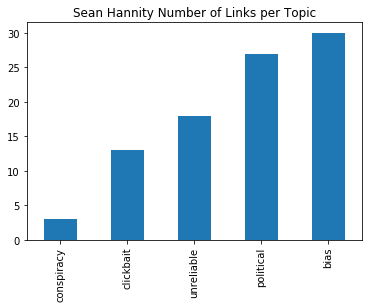

In [45]:
# we'll filter out the non-represented classes, sort them, and plot it!
breakdown[breakdown != 0].sort_values().plot(
    kind='bar', title='Sean Hannity Number of Links per Topic'
)